In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import pickle
import mne

In [2]:
cd MOABB_ERP_data/

C:\Users\Admin\Documents\BMI_mid_project\MOABB_ERP_data


In [3]:
NU_data   = 'data_allsubjects.pickle'
ALS_data  = 'ALSdata.pickle'
EPFLP_data = 'EPFLP300.pickle'
BNCI_data = 'BNCI2015003.pickle'

### Load dataset
Load EEG data for visualization

In [4]:
# Datasets
itemname = [NU_data, ALS_data, EPFLP_data, BNCI_data]

In [5]:
def loaddata(filename):
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    return data

import pickle

for item in itemname:
    filename = item
    data = loaddata(filename)
    print('EEG data is 3D numpy array (trials x channels x time samples) ---->')
    print('Number of subjects in %s: %d' % (item, len(data)))
    count = 0
    for subject in range(len(data)):
        print('Subject', subject, ':', data[subject].get_data().shape)
        count += data[subject].get_data().shape[0]
    print('Total : (', count, ',', data[subject].get_data().shape[1], ',', 
          data[subject].get_data().shape[2], ')')
    print(" ")

EEG data is 3D numpy array (trials x channels x time samples) ---->
Number of subjects in data_allsubjects.pickle: 16
Subject 0 : (3982, 16, 76)
Subject 1 : (3916, 16, 76)
Subject 2 : (2053, 16, 76)
Subject 3 : (6516, 16, 76)
Subject 4 : (3396, 16, 76)
Subject 5 : (3975, 16, 76)
Subject 6 : (1163, 16, 76)
Subject 7 : (1174, 16, 76)
Subject 8 : (4139, 16, 76)
Subject 9 : (4047, 16, 76)
Subject 10 : (4060, 16, 76)
Subject 11 : (4067, 16, 76)
Subject 12 : (4083, 16, 76)
Subject 13 : (4024, 16, 76)
Subject 14 : (2263, 16, 76)
Subject 15 : (3809, 16, 76)
Total : ( 56667 , 16 , 76 )
 
EEG data is 3D numpy array (trials x channels x time samples) ---->
Number of subjects in ALSdata.pickle: 8
Subject 0 : (4200, 8, 78)
Subject 1 : (4200, 8, 78)
Subject 2 : (4200, 8, 78)
Subject 3 : (4200, 8, 78)
Subject 4 : (4200, 8, 78)
Subject 5 : (4200, 8, 78)
Subject 6 : (4200, 8, 78)
Subject 7 : (4200, 8, 78)
Total : ( 33600 , 8 , 78 )
 
EEG data is 3D numpy array (trials x channels x time samples) ---->
N


BNCI Data info 
---



In [64]:
data = loaddata(itemname[2])

In [60]:
# select data from a specific subject and use it for demostration
subject = 0
s1 = data[subject] # s1['Target']
print(s1)

<Epochs |  3342 events (all good), 0 - 0.59375 sec, baseline off, ~62.9 MB, data loaded,
 'Target': 557
 'NonTarget': 2785>


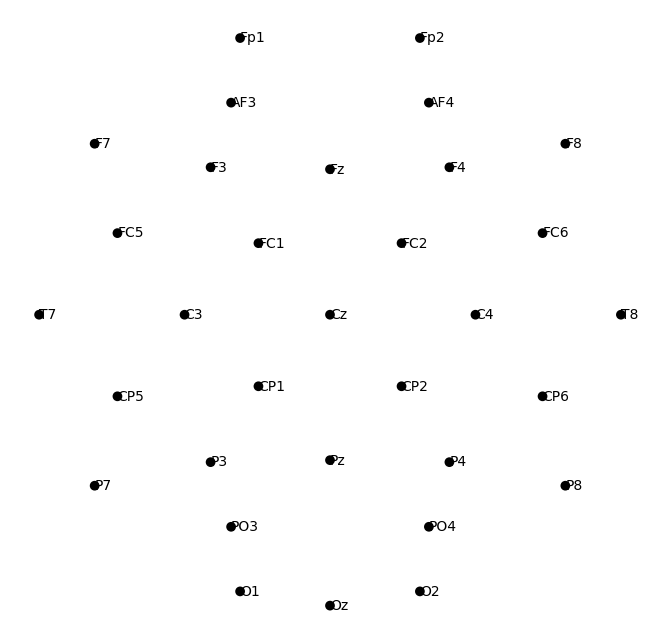

In [61]:
s1.plot_sensors(title = 'EEG sensor locations and labels', show_names = True);

### Apply common-average reference

### Band-pass filter


## Scikit-learn

In [73]:
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit, GridSearchCV, LeaveOneOut
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, explained_variance_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


import warnings
warnings.filterwarnings("ignore")

In [9]:
#==============================
# Binary Classification setting: 
#=============================
# Y = 1 => Target Stimulus (a character/letter in the matrix that a user wants to spell) 
# Y = 0 => Non-Target Stimulus

In [10]:
# Alternative way:

# X, Y = [], []     

# X = np.concatenate([target.get_data(), nontarget.get_data()])            
# Y = np.concatenate([np.ones(target.get_data().shape[0]), np.zeros(nontarget.get_data().shape[0])])  
# ------------------------------------------------------------------------------

In [65]:
X,y = [],[]

for i in range(len(data)):
    #data[i] = data[i].set_eeg_reference(ref_channels='average')
    epoch = data[i].pick_types(eeg=True)
    d = epoch.get_data()
    X.append(d)    
    l = epoch.events[:, -1]
    y.append(l)

In [66]:
nX = np.concatenate(X)
nX = np.reshape(nX,[26640, 32*77])

In [67]:
nY = np.empty(shape = y[0].shape)
for i in range(len(y)):
    nY = np.concatenate([nY,y[i]])
nY = np.concatenate(y)

In [68]:
print(nX.shape)
print(nY.shape)

(26640, 2464)
(26640,)


In [69]:
# To split the data in 80:10:10 for train:valid:test dataset
# First, I will split the data in training and remaining temporary dataset
X_train, X_temp, y_train, y_temp = train_test_split(nX, nY, train_size = 0.8, random_state=42, stratify = nY)

# Second, I will divide the remaining temp dataset 50 by 50
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state=42)

print("Train dataset")
print(X_train.shape), print(y_train.shape)
print(" ")
print("Validation dataset")
print(X_valid.shape), print(y_valid.shape)
print(" ")
print("Test dataset")
print(X_test.shape), print(y_test.shape)

Train dataset
(21312, 2464)
(21312,)
 
Validation dataset
(2664, 2464)
(2664,)
 
Test dataset
(2664, 2464)
(2664,)


(None, None)

## Vectorizer()

In [16]:
from mne.decoding import Vectorizer
from datetime import datetime as dt

In [70]:
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
     
    return "Time taken:  %d h : %02d mins : %02d secs" % (hour, minutes, seconds)

## Simple Model Training

In [18]:
classifiers = {
    "KNN": KNeighborsClassifier(n_neighbors=9, weights='distance'), 
    "LR": LogisticRegression(solver='lbfgs', max_iter = 1000), 
    "LDA": LinearDiscriminantAnalysis(),
    #"DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(max_iter=10000),
    "MLP": MLPClassifier(activation='relu', solver='adam', max_iter=500)
}

In [19]:
def evaluate_models(models, X_train, X_valid, y_train, y_valid):
    results = pd.DataFrame(columns=["Classifier", "Train_Acc", "Valid_Acc"])
    for name, model in models.items():
        model.fit(X_train, y_train)
        train_acc = model.score(X_train, y_train)
        valid_acc = model.score(X_valid, y_valid)
        results = results.append({
            "Classifier": name,
            "Train_Acc": train_acc,
            "Valid_Acc": valid_acc
        }, ignore_index=True) 
        
        print('%s : Train/Valid Acc: %.3f/%.3f' % (name, train_acc, valid_acc))  
    print(results)
    return results

In [20]:
start = dt.now()

res_models = evaluate_models(classifiers, X_train, X_valid, y_train, y_valid)

running_secs = (dt.now() - start).seconds
print(convert(running_secs))

#results

KNN : Train/Valid Acc: 1.000/0.837
LR : Train/Valid Acc: 0.658/0.636
LDA : Train/Valid Acc: 0.845/0.841
RF : Train/Valid Acc: 1.000/0.839
SVM : Train/Valid Acc: 0.834/0.837
MLP : Train/Valid Acc: 0.811/0.812
  Classifier  Train_Acc  Valid_Acc
0        KNN   1.000000   0.837087
1         LR   0.658361   0.635886
2        LDA   0.845439   0.840841
3         RF   0.999953   0.839339
4        SVM   0.833568   0.837462
5        MLP   0.811139   0.812312
Time taken:  0 h : 11 mins : 21 secs


In [21]:
print(res_models)

  Classifier  Train_Acc  Valid_Acc
0        KNN   1.000000   0.837087
1         LR   0.658361   0.635886
2        LDA   0.845439   0.840841
3         RF   0.999953   0.839339
4        SVM   0.833568   0.837462
5        MLP   0.811139   0.812312


In [74]:
def evaluate_models2222(models, X_train, X_valid, y_train, y_valid):
    results = pd.DataFrame(columns=["Classifier", "Train_Acc", "Valid_Acc", "Valid_f1", "Valid_variance"])
    for name, model in models.items():
        model.fit(X_train, y_train)
        train_acc = model.score(X_train, y_train)
        valid_acc = model.score(X_valid, y_valid)
        y_pred = model.predict(X_valid)
        f1score = f1_score(y_valid,y_pred)
        val = explained_variance_score(y_valid,y_pred)
        results = results.append({
            "Classifier": name,
            "Train_Acc": train_acc,
            "Valid_Acc": valid_acc,
            "Valid_f1": f1score,
            "Valid_variance": val
        }, ignore_index=True) 
        
        print('%s : Train/Valid_Acc/F1/Variance: %.3f/%.3f/%.3f/%.3f' % (name, train_acc, valid_acc, f1score, val))  
    return results

In [75]:
start = dt.now()

res_models2222 = evaluate_models2222(classifiers, X_train, X_valid, y_train, y_valid)

running_secs = (dt.now() - start).seconds
print(convert(running_secs))

KNN : Train/Valid_Acc/F1/Variance: 1.000/0.837/0.910/-0.063
LR : Train/Valid_Acc/F1/Variance: 0.658/0.636/0.757/-1.454
LDA : Train/Valid_Acc/F1/Variance: 0.845/0.841/0.911/-0.070
RF : Train/Valid_Acc/F1/Variance: 1.000/0.838/0.911/-0.017
SVM : Train/Valid_Acc/F1/Variance: 0.834/0.837/0.912/0.000
MLP : Train/Valid_Acc/F1/Variance: 0.810/0.812/0.895/-0.273
Time taken:  0 h : 12 mins : 12 secs


In [76]:
res_models2222

,Classifier,Train_Acc,Valid_Acc,Valid_f1,Valid_variance
0,KNN,1.000000,0.837087,0.909996,-0.062683
1,LR,0.658361,0.635886,0.757500,-1.454016
2,LDA,0.845439,0.840841,0.911148,-0.069784
3,RF,0.999953,0.838213,0.911481,-0.017093
4,SVM,0.833568,0.837462,0.911542,0.000000
5,MLP,0.809966,0.812312,0.895441,-0.272848


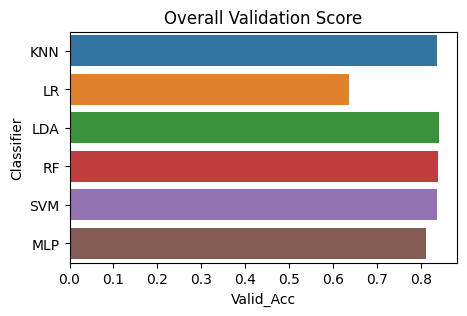

In [22]:
plt.figure(figsize=(5,3))
sns.barplot(data=res_models, x="Valid_Acc", y="Classifier")
plt.title("Overall Validation Score")
plt.show()

## Model training with CV

In [23]:
cross_val = {
    "Simple_5": 5,
    "Stratified": StratifiedKFold(n_splits=5),
    "Shuffled": ShuffleSplit(n_splits=5, test_size=.2)   
}

In [24]:
def evaluate_models_with_CV(models, cv, X, y):
    results = pd.DataFrame(columns=["Classifier", "Simple_5", "Stratified", "Shuffled"])
    for name, model in models.items():
        print('%s model training started -------------------->' % name) 
        scores = []
        for cv_name, cv in cross_val.items():
            mean_score = np.mean(cross_val_score(model, nX, nY, cv = cv)) 
            scores.append(mean_score)
            print('%s is finished' % cv_name) 
        results = results.append({
            "Classifier": name,
            "Simple_5": scores[0],  
            "Stratified": scores[1], 
            "Shuffled": scores[2] 
        }, ignore_index=True)
        print(" ")
    return results

In [25]:
start = dt.now()

res_CV = evaluate_models_with_CV(classifiers, cross_val, nX, nY)

running_secs = (dt.now() - start).seconds
print(convert(running_secs))

KNN model training started -------------------->
Simple_5 is finished
Stratified is finished
Shuffled is finished
 
LR model training started -------------------->
Simple_5 is finished
Stratified is finished
Shuffled is finished
 
LDA model training started -------------------->
Simple_5 is finished
Stratified is finished
Shuffled is finished
 
RF model training started -------------------->
Simple_5 is finished
Stratified is finished
Shuffled is finished
 
SVM model training started -------------------->
Simple_5 is finished
Stratified is finished
Shuffled is finished
 
MLP model training started -------------------->
Simple_5 is finished
Stratified is finished
Shuffled is finished
 
Time taken:  2 h : 03 mins : 26 secs


In [29]:
res_CV

,Classifier,Simple_5,Stratified,Shuffled
0,KNN,0.828153,0.828153,0.828078
1,LR,0.603378,0.603378,0.641441
2,LDA,0.811411,0.811411,0.829429
3,RF,0.827477,0.826314,0.833183
4,SVM,0.833333,0.833333,0.829429
5,MLP,0.724062,0.774925,0.721471


## Model training with Vectorizer() and StandardScaler()

In [30]:
def evaluate_models_with_normalization(models, X_train, X_valid, y_train, y_valid):
    results = pd.DataFrame(columns=["Classifier", "Train_Acc", "Valid_Acc"])
    for name, model in models.items():
        model = make_pipeline(Vectorizer(), StandardScaler(), model)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_valid)
        valid_acc = accuracy_score(y_valid,y_pred)
        train_acc = model.score(X_train, y_train)

        results = results.append({
            "Classifier": name,
            "Train_Acc": train_acc,
            "Valid_Acc": valid_acc
        }, ignore_index=True) 
        
        print('%s model finished training' % name)
    return results

In [31]:
start = dt.now()

res_norm = evaluate_models_with_normalization(classifiers, X_train, X_valid, y_train, y_valid)

running_secs = (dt.now() - start).seconds
print(convert(running_secs))

KNN model finished training
LR model finished training
LDA model finished training
RF model finished training
SVM model finished training
MLP model finished training
Time taken:  0 h : 13 mins : 16 secs


In [32]:
res_norm

,Classifier,Train_Acc,Valid_Acc
0,KNN,1.000000,0.835961
1,LR,0.833990,0.835961
2,LDA,0.845439,0.840841
3,RF,1.000000,0.839715
4,SVM,0.833568,0.837462
5,MLP,0.833943,0.837462


In [77]:
def evaluate_models_with_normalization2222(models, X_train, X_valid, y_train, y_valid):
    results = pd.DataFrame(columns=["Classifier", "Train_Acc", "Valid_Acc", "Valid_f1", "Valid_variance"])
    for name, model in models.items():
        model = make_pipeline(Vectorizer(), StandardScaler(), model)
        model.fit(X_train, y_train)
        train_acc = model.score(X_train, y_train)
        valid_acc = model.score(X_valid, y_valid)
        y_pred = model.predict(X_valid)
        f1score = f1_score(y_valid,y_pred)
        val = explained_variance_score(y_valid,y_pred)
        results = results.append({
            "Classifier": name,
            "Train_Acc": train_acc,
            "Valid_Acc": valid_acc,
            "Valid_f1": f1score,
            "Valid_variance": val
        }, ignore_index=True) 
        
        print('%s : Train/Valid_Acc/F1/Variance: %.3f/%.3f/%.3f/%.3f' % (name, train_acc, valid_acc, f1score, val))  
    return results

In [78]:
start = dt.now()

res_norm2222 = evaluate_models_with_normalization2222(classifiers, X_train, X_valid, y_train, y_valid)

running_secs = (dt.now() - start).seconds
print(convert(running_secs))

KNN : Train/Valid_Acc/F1/Variance: 1.000/0.836/0.909/-0.072
LR : Train/Valid_Acc/F1/Variance: 0.834/0.836/0.911/-0.015
LDA : Train/Valid_Acc/F1/Variance: 0.845/0.841/0.911/-0.070
RF : Train/Valid_Acc/F1/Variance: 1.000/0.837/0.911/-0.018
SVM : Train/Valid_Acc/F1/Variance: 0.834/0.837/0.912/0.000
MLP : Train/Valid_Acc/F1/Variance: 0.834/0.837/0.911/-0.004
Time taken:  0 h : 12 mins : 23 secs


In [79]:
res_norm2222

,Classifier,Train_Acc,Valid_Acc,Valid_f1,Valid_variance
0,KNN,1.000000,0.835961,0.909355,-0.071700
1,LR,0.833990,0.835961,0.910652,-0.014600
2,LDA,0.845439,0.840841,0.911148,-0.069784
3,RF,0.999953,0.836712,0.910879,-0.017863
4,SVM,0.833568,0.837462,0.911542,0.000000
5,MLP,0.833662,0.837087,0.911320,-0.003653


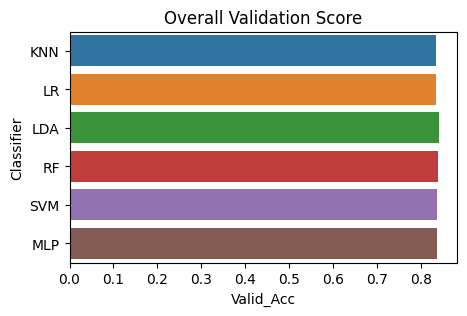

In [33]:
plt.figure(figsize=(5,3))
sns.barplot(data=res_norm, x="Valid_Acc", y="Classifier")
plt.title("Overall Validation Score")
plt.show()

## Model training with CV and Vectorizer() and StandardScaler()

In [34]:
def evaluate_models_with_CV_normal(models, cv, X, y):
    results = pd.DataFrame(columns=["Classifier", "Simple_5", "Stratified", "Shuffled"])
    for name, model in models.items():
        model = make_pipeline(Vectorizer(), StandardScaler(), model)
        print('%s model training started -------------------->' % name) 
        scores = []
        for cv_name, cv in cross_val.items():
            mean_score = np.mean(cross_val_score(model, nX, nY, cv = cv)) 
            scores.append(mean_score)
            print('%s is finished' % cv_name) 
        results = results.append({
            "Classifier": name,
            "Simple_5": scores[0],  
            "Stratified": scores[1], 
            "Shuffled": scores[2] 
        }, ignore_index=True)
        print(" ")
    return results

In [35]:
start = dt.now()

res_CV_norm = evaluate_models_with_CV_normal(classifiers, cross_val, nX, nY)

running_secs = (dt.now() - start).seconds
print(convert(running_secs))

KNN model training started -------------------->
Simple_5 is finished
Stratified is finished
Shuffled is finished
 
LR model training started -------------------->
Simple_5 is finished
Stratified is finished
Shuffled is finished
 
LDA model training started -------------------->
Simple_5 is finished
Stratified is finished
Shuffled is finished
 
RF model training started -------------------->
Simple_5 is finished
Stratified is finished
Shuffled is finished
 
SVM model training started -------------------->
Simple_5 is finished
Stratified is finished
Shuffled is finished
 
MLP model training started -------------------->
Simple_5 is finished
Stratified is finished
Shuffled is finished
 
Time taken:  12 h : 30 mins : 59 secs


In [36]:
res_CV_norm

,Classifier,Simple_5,Stratified,Shuffled
0,KNN,0.827628,0.827628,0.832620
1,LR,0.827965,0.827965,0.832020
2,LDA,0.811411,0.811411,0.831757
3,RF,0.827890,0.825300,0.835285
4,SVM,0.833333,0.833333,0.829805
5,MLP,0.831494,0.831194,0.830781


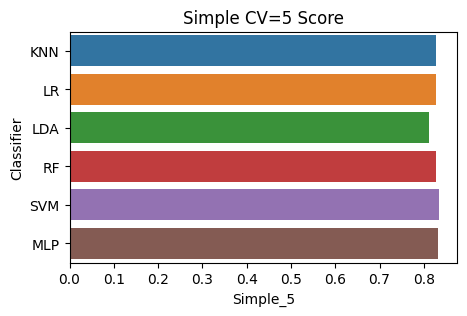

In [37]:
plt.figure(figsize=(5,3))
sns.barplot(data=res_CV_norm, x="Simple_5", y="Classifier")
plt.title("Simple CV=5 Score")
plt.show()

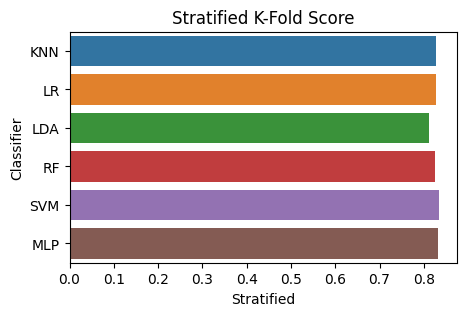

In [38]:
plt.figure(figsize=(5,3))
sns.barplot(data=res_CV_norm, x="Stratified", y="Classifier")
plt.title("Stratified K-Fold Score")
plt.show()

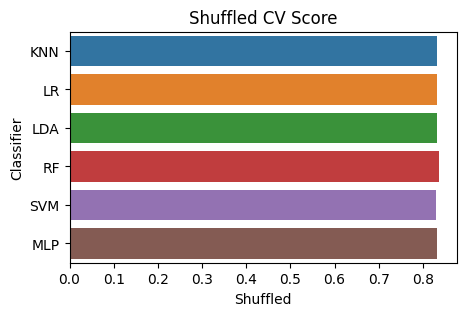

In [39]:
plt.figure(figsize=(5,3))
sns.barplot(data=res_CV_norm, x="Shuffled", y="Classifier")
plt.title("Shuffled CV Score")
plt.show()

## Model training with Ensemble Learning

In [40]:
from sklearn.ensemble import VotingClassifier

In [43]:
def get_models2():
    models = list()
    models.append(('lda',LinearDiscriminantAnalysis()))
    models.append(('svc',SVC(probability=True)))
    models.append(('rf', RandomForestClassifier(n_estimators=100)))
    return models

def evaluate_models2(models,X_train,X_val,y_train,y_val):
    scores = list()
    for name, model in models:
        model.fit(X_train,y_train)
        yhat = model.predict(X_val)
        acc = accuracy_score(y_val,yhat)
        scores.append(acc)
    return scores

In [44]:
models = get_models2()
scores = evaluate_models2(models, X_train, X_test, y_train, y_test)

In [45]:
ensemble = VotingClassifier(estimators=models, voting='soft', weights=scores)
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
score = accuracy_score(y_test, y_pred)
print('Weighted Avg Accuracy: %.3f' % (score*100))

Weighted Avg Accuracy: 82.808


# Subject Specific

## Model training with normalization and vectorizer()

In [46]:
def get_subject_data(subject):
    epochs = subject.pick_types(eeg=True)
    X = epochs.get_data()
    y = epochs.events[:, -1]
    return X, y

In [81]:
classifiers = { 
    "LDA": LinearDiscriminantAnalysis(),
    "RF": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(max_iter=10000)
}

In [82]:
X, y = get_subject_data(s1)

In [83]:
start = dt.now()

for s in range(len(data)):
    subject = data[s]
    X, y = get_subject_data(subject)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42, stratify = y)
    print('Started Subject %s data training -------------->' % (s+1))
    res_models_ss = evaluate_models_with_normalization2222(classifiers, X_train, X_test, y_train, y_test)
    print(res_models_ss)
    print(" ")
    
running_secs = (dt.now() - start).seconds
print(convert(running_secs))

Started Subject 1 data training -------------->
LDA : Train/Valid_Acc/F1/Variance: 0.960/0.800/0.879/-0.446
RF : Train/Valid_Acc/F1/Variance: 1.000/0.862/0.923/0.120
SVM : Train/Valid_Acc/F1/Variance: 0.834/0.834/0.910/0.000
  Classifier  Train_Acc  Valid_Acc  Valid_f1  Valid_variance
0        LDA   0.960344   0.799701  0.879061       -0.446317
1         RF   1.000000   0.862481  0.923333        0.120217
2        SVM   0.833895   0.834081  0.909535        0.000000
 
Started Subject 2 data training -------------->
LDA : Train/Valid_Acc/F1/Variance: 0.958/0.818/0.890/-0.307
RF : Train/Valid_Acc/F1/Variance: 1.000/0.832/0.908/-0.021
SVM : Train/Valid_Acc/F1/Variance: 0.834/0.833/0.909/0.000
  Classifier  Train_Acc  Valid_Acc  Valid_f1  Valid_variance
0        LDA   0.957879   0.818045  0.889699       -0.306534
1         RF   1.000000   0.831579  0.907895       -0.021498
2        SVM   0.834148   0.833083  0.908942        0.000000
 
Started Subject 3 data training -------------->
LDA : Tra

## Apply CAR and/or Band-pass filter

In [49]:
data = loaddata(itemname[2])

In [50]:
start = dt.now()

for s in range(len(data)):
    subject = data[s]
    subject.set_eeg_reference(ref_channels='average')
    X, y = get_subject_data(subject)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42, stratify = y)
    print('Started Subject %s data training -------------->' % (s+1))
    res_models_ss = evaluate_models_with_normalization(classifiers, X_train, X_test, y_train, y_test)
    print(res_models_ss)
    print(" ")
    
running_secs = (dt.now() - start).seconds
print(convert(running_secs))

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Started Subject 1 data training -------------->
KNN model finished training
LR model finished training
LDA model finished training
RF model finished training
SVM model finished training
MLP model finished training
  Classifier  Train_Acc  Valid_Acc
0        KNN   1.000000   0.837070
1         LR   0.902357   0.846039
2        LDA   0.961092   0.783259
3         RF   1.000000   0.857997
4        SVM   0.834269   0.834081
5        MLP   0.976431   0.820628
 
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Started Subject 2 data training -------------->
KNN model finished training
LR model finished training
LDA model finished training
RF model finished training
SVM model finished training
MLP model finished training
  Classifier  Train_Acc  Valid_Acc
0        KNN   1.000000   0.834586
1         LR   0.893569   0.85413

## ICA Decomposition

In [51]:
ica = mne.preprocessing.ICA(n_components=32, random_state=0) #n_components = less than or equal to the number of channels

In [52]:
data = loaddata(itemname[2])

In [53]:
X,y = [],[]

for i in range(len(data)):
    # ICA applied for each subject separately
    ica.fit(data[i].copy().filter(8, 35))
    bad_idx, scores = ica.find_bads_eog(data[i], 'Fz', threshold=1.5)
    ica.exclude = bad_idx
    subj = ica.apply(data[i].copy(), exclude=ica.exclude)
    
    # Adding each subject to a an array
    epoch = subj.pick_types(eeg=True)
    d = epoch.get_data()
    X.append(d)    
    l = epoch.events[:, -1]
    y.append(l)

Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 213 samples (1.664 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 32 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 106944 out of 106944 | elapsed:   21.0s finished


Selecting by number: 32 components
Fitting ICA took 14.4s.
Using EOG channel: Fz
Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 213 samples (1.664 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 32 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 106368 out of 106368 | elapsed:   21.2s finished


Selecting by number: 32 components
Fitting ICA took 12.6s.
Using EOG channel: Fz
Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 213 samples (1.664 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 32 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 106944 out of 106944 | elapsed:   20.4s finished


Selecting by number: 32 components
Fitting ICA took 14.0s.
Using EOG channel: Fz
Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 213 samples (1.664 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 32 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 106176 out of 106176 | elapsed:   21.1s finished


Selecting by number: 32 components
Fitting ICA took 19.2s.
Using EOG channel: Fz
Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 213 samples (1.664 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 32 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 105600 out of 105600 | elapsed:   20.9s finished


Selecting by number: 32 components
Fitting ICA took 14.7s.
Using EOG channel: Fz
Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 8 ICA components
    Projecting back using 32 PCA components
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 213 samples (1.664 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 32 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 107904 out of 107904 | elapsed:   20.5s finished


Selecting by number: 32 components
Fitting ICA took 13.8s.
Using EOG channel: Fz
Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 213 samples (1.664 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 32 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 106752 out of 106752 | elapsed:   20.9s finished


Selecting by number: 32 components
Fitting ICA took 19.1s.
Using EOG channel: Fz
Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 213 samples (1.664 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 32 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 105792 out of 105792 | elapsed:   19.2s finished


Selecting by number: 32 components
Fitting ICA took 14.6s.
Using EOG channel: Fz
Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


In [54]:
nX = np.concatenate(X)
nX = np.reshape(nX,[26640, 32*77])

In [55]:
nY = np.empty(shape = y[0].shape)
for i in range(len(y)):
    nY = np.concatenate([nY,y[i]])
nY = np.concatenate(y)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(nX, nY, train_size = 0.8, random_state=42, stratify = nY)

In [57]:
start = dt.now()

res_models_ica = evaluate_models(classifiers, X_train, X_test, y_train, y_test)

running_secs = (dt.now() - start).seconds
print(convert(running_secs))

KNN : Train/Valid Acc: 1.000/0.835
LR : Train/Valid Acc: 0.687/0.651
LDA : Train/Valid Acc: 0.849/0.828
RF : Train/Valid Acc: 1.000/0.832
SVM : Train/Valid Acc: 0.835/0.833
MLP : Train/Valid Acc: 0.809/0.804
  Classifier  Train_Acc  Valid_Acc
0        KNN   1.000000   0.835023
1         LR   0.687125   0.650901
2        LDA   0.849334   0.828078
3         RF   1.000000   0.831832
4        SVM   0.834788   0.833333
5        MLP   0.808746   0.804429
Time taken:  0 h : 11 mins : 09 secs
